In [484]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import zipfile


In [485]:
historical_data = 'https://arcgis.com/sharing/rest/content/items/b860f2797f7f4da789cb6fccf6bd5bc7/data'
actual_data = 'https://arcgis.com/sharing/rest/content/items/3f47db945aff47e582db8aa383ccf3a1/data'

historical_tmp = 'htmp'
actual_tmp = 'atmp'

download_pairs = [
    (historical_data, historical_tmp),
    (actual_data, actual_tmp)
]

for download_data, download_tmp in download_pairs:
    response = requests.get(download_data, stream=True)
    with open(download_tmp, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

4409660it [00:26, 164456.16it/s]


KeyboardInterrupt: 

In [4]:
historical_tmp_dir = historical_tmp + '_dir'
actual_tmp_dir = actual_tmp + '_dir'
unzip_pairs = [
    (historical_tmp, historical_tmp_dir),
    (actual_tmp, actual_tmp_dir)
]

for download_tmp, unzip_dir in unzip_pairs:
    with zipfile.ZipFile(download_tmp, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

In [545]:
suffix = '_rap_rcb_global_szczepienia'
timeline_stats = '20220528074633_rap_rcb_daily_szczepienia.csv'
last_date = '2022-05-21'
df_time = pd.read_csv(os.path.join(actual_tmp_dir, timeline_stats), sep=';')
df_time = df_time.query(f'data <= "{last_date}"')
df_time.index = df_time.data
df_time = df_time[[col for col in df_time.columns if col != 'data']]
df_time.tail()

,liczba_szczepien_dziennie,dawka_2_dziennie,dawka_1_dziennie,dawka_3_dziennie,dawka_przypomianjaca_dziennie
data,,,,,
2022-05-17,9462,627,2638,59,6138
2022-05-18,8239,681,1251,102,6205
2022-05-19,9047,754,1614,65,6614
2022-05-20,11969,1235,1573,103,9058
2022-05-21,3401,333,677,20,2371


In [487]:
df_details = None
for p in sorted(os.listdir(historical_tmp_dir)):
    if p.endswith(suffix + '.csv'):
        df_current = pd.read_csv(os.path.join(historical_tmp_dir, p), sep=';')
        vaccination_cols = sorted([col for col in df_current.columns if col.startswith('szczepienia')])
        df_current['data'] = f'{p[:4]}-{p[4:6]}-{p[6:8]}'
        df_current = df_current[['data'] + vaccination_cols]
        if df_details is None:
            df_details = df_current
        else:
            df_details = pd.concat([df_details, df_current])

In [488]:
df_details.index = df_details['data']

In [489]:
df_details = df_details[[col for col in df_details.columns if col != 'data']]
df_details.diff()[df_details.diff()<0].sum()

szczepienia0_17                -20316.0
szczepienia18_30                -9163.0
szczepienia31_40                -5118.0
szczepienia41_50                 -703.0
szczepienia51_60                -3228.0
szczepienia61_70               -13821.0
szczepienia71_75                -6206.0
szczepienia75_                 -10303.0
szczepienia_kobiety             -4353.0
szczepienia_mezczyzni            -538.0
szczepienia_plec_nieustalono    -3648.0
szczepienia_wiek_nieustalono    -1397.0
dtype: float64

In [490]:
cols_age = ['szczepienia0_17', 'szczepienia18_30', 'szczepienia31_40',
       'szczepienia41_50', 'szczepienia51_60', 'szczepienia61_70',
       'szczepienia71_75', 'szczepienia75_', 'szczepienia_wiek_nieustalono']

In [491]:
df_details[cols_age].diff().sum(axis=1).tail(n=10)

data
2022-05-10     8735.0
2022-05-11     8568.0
2022-05-12    11241.0
2022-05-13     9203.0
2022-05-14     7787.0
2022-05-15     2505.0
2022-05-16      681.0
2022-05-17     7273.0
2022-05-18    21523.0
2022-05-19     8177.0
dtype: float64

In [492]:
df_time.rolling(window=14, min_periods=1).mean().loc[df_details.index].cumsum()

,liczba_szczepien_dziennie,dawka_2_dziennie,dawka_1_dziennie,dawka_3_dziennie,dawka_przypomianjaca_dziennie
data,,,,,
2021-01-13,2.438057e+04,7.142857e-01,2.437971e+04,0.142857,0.000000e+00
2021-01-14,5.132993e+04,1.642857e+00,5.132807e+04,0.214286,0.000000e+00
2021-01-15,8.005786e+04,2.500000e+00,8.005507e+04,0.285714,0.000000e+00
2021-01-16,1.101239e+05,4.571429e+00,1.101189e+05,0.357143,0.000000e+00
2021-01-17,1.410067e+05,3.771429e+01,1.409686e+05,0.428571,0.000000e+00
...,...,...,...,...,...
2022-05-15,5.418073e+07,1.966706e+07,2.242629e+07,225119.857143,1.186225e+07
2022-05-16,5.418883e+07,1.966768e+07,2.242775e+07,225187.714286,1.186820e+07
2022-05-17,5.419758e+07,1.966834e+07,2.242940e+07,225259.785714,1.187458e+07


In [493]:
for col in df_time:
    if col != 'liczba_szczepien_dziennie':
        df_time[col] /= df_time['liczba_szczepien_dziennie'].to_numpy()
df_time['liczba_szczepien_dziennie'] = 1
df_time['shot1'] = df_time['dawka_1_dziennie']
df_time['shot2'] = df_time['dawka_2_dziennie']
df_time['shot3'] = 1 - df_time['shot1'] - df_time['shot2']


In [494]:
df_time = df_time[[col for col in df_time.columns if 'shot' in col]]
df_time[df_time<0] = 0
df_time = df_time.loc[df_details.index]
df_time

,shot1,shot2,shot3
data,,,
2021-01-13,0.999982,0.000018,3.617508e-17
2021-01-14,0.999936,0.000064,3.581933e-17
2021-01-15,0.999962,0.000038,0.000000e+00
2021-01-16,0.999190,0.000810,0.000000e+00
2021-01-17,0.963978,0.036022,0.000000e+00
...,...,...,...
2022-05-15,0.645690,0.029310,3.250000e-01
2022-05-16,0.263700,0.058587,6.777133e-01
2022-05-17,0.278799,0.066265,6.549355e-01


<AxesSubplot:xlabel='data'>

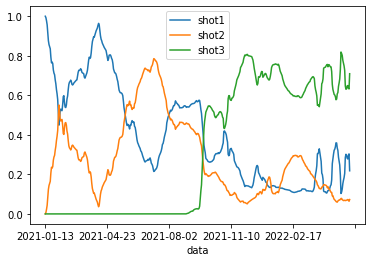

In [495]:
df_time.rolling(window=7, min_periods=1, center=True).mean().plot()

<AxesSubplot:xlabel='data'>

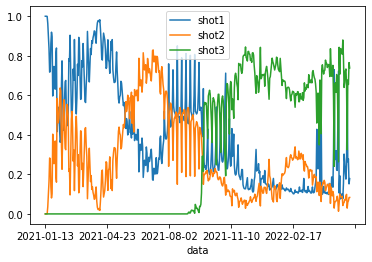

In [496]:
df_time.rolling(window=1, min_periods=1).mean().plot()

<AxesSubplot:xlabel='data'>

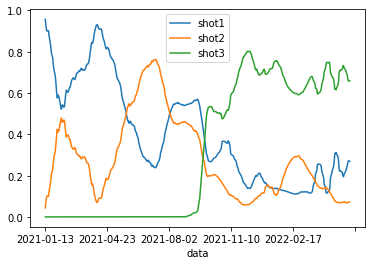

In [497]:
df_time.rolling(window=14, min_periods=1, center=True).mean().plot()

In [498]:
df_time_average = df_time.rolling(window=7, min_periods=1, center=True).mean()

In [499]:
df_time_average = df_time_average.groupby('data').mean()

In [500]:
df_time_average['shot1']['2021-05-06']

0.7180381667484163

In [501]:
future_frequencies = df_time_average.loc['2022-05-19'].to_dict()
future_frequencies

{'shot1': 0.21818493744994039,
 'shot2': 0.0727125204583644,
 'shot3': 0.7091025420916953}

In [502]:
daily_increments = df_details[cols_age[:-1]].diff()
for col in daily_increments:
    daily_increments[col] = daily_increments[col].apply(lambda x: max(0, x))
daily_increments

,szczepienia0_17,szczepienia18_30,szczepienia31_40,szczepienia41_50,szczepienia51_60,szczepienia61_70,szczepienia71_75,szczepienia75_
data,,,,,,,,
2021-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-14,10.0,9257.0,9729.0,13257.0,14023.0,7180.0,981.0,788.0
2021-01-15,0.0,9252.0,7932.0,10598.0,10973.0,5614.0,819.0,760.0
2021-01-16,0.0,5390.0,4669.0,5945.0,6161.0,3261.0,525.0,496.0
2021-01-17,0.0,3594.0,3602.0,4667.0,4736.0,2912.0,439.0,357.0
...,...,...,...,...,...,...,...,...
2022-05-15,0.0,0.0,0.0,184.0,67.0,0.0,83.0,3053.0
2022-05-16,0.0,0.0,0.0,0.0,0.0,25.0,898.0,1832.0
2022-05-17,0.0,1228.0,1004.0,870.0,462.0,0.0,1497.0,2675.0


In [503]:
future_daily_new_vaccines = daily_increments.rolling(window=14, min_periods=1).mean().loc['2022-05-19'].to_dict()
future_daily_new_vaccines

{'szczepienia0_17': 166.07142857142858,
 'szczepienia18_30': 1063.2142857142858,
 'szczepienia31_40': 814.5,
 'szczepienia41_50': 1039.142857142857,
 'szczepienia51_60': 519.2857142857143,
 'szczepienia61_70': 141.71428571428572,
 'szczepienia71_75': 1127.5714285714287,
 'szczepienia75_': 3722.9285714285716}

In [504]:
df_pl_ages = pd.read_csv('/Users/marcinbodych/Workspace/ImmunityUptakes/notebooks/age_id.csv')

age_cols = list(shot3_df.columns)
def get_age_limits(age_col, max_age):
    age_limits = age_col.replace('szczepienia','').split('_')
    start_age = int(age_limits[0])
    end_age = max_age
    if len(age_limits[1]) > 0:
        end_age = int(age_limits[1])
    else:
        start_age += 1
    end_age += 1
    return start_age, end_age


max_age = df_pl_ages.age.unique().max()

age_limits2 = {age: key for key in age_cols for age in np.arange(*get_age_limits(key, max_age))}
age_limits2

df_pl_ages['group'] = df_pl_ages['age'].map(age_limits2)
age_group_to_idx = df_pl_ages.groupby('group')['id'].apply(list)

age_group_to_idx_dict = age_group_to_idx.to_dict()

population_in_age_groups = defaultdict(int)
for k, v in age_group_to_idx_dict.items():
    population_in_age_groups[k] = len(v)
population_in_age_groups

doses_coverage_in_age_groups = {
    'szczepienia0_17': {'shot1': 0.254, 'shot2': 0.241, 'shot3': 0.029},
    'szczepienia18_30': {'shot1': 0.594, 'shot2': 0.582, 'shot3': 0.182},
    'szczepienia31_40': {'shot1': 0.617, 'shot2': 0.609, 'shot3': 0.264},
    'szczepienia41_50': {'shot1': 0.617, 'shot2': 0.609, 'shot3': 0.264},
    'szczepienia51_60': {'shot1': 0.699, 'shot2': 0.693, 'shot3': 0.422},
    'szczepienia61_70': {'shot1': 0.761, 'shot2': 0.759, 'shot3': 0.583},
    'szczepienia71_75': {'shot1': 0.761, 'shot2': 0.759, 'shot3': 0.583},
    'szczepienia75_': {'shot1': 0.761, 'shot2': 0.759, 'shot3': 0.583},
}

from collections import defaultdict

corrections = defaultdict(dict)

for shot in df_time_average.columns:
    tmp = defaultdict(int)
    normalization1 = 0
    for day, row in daily_increments.iterrows():
        for col in daily_increments:
            day_age = np.round(row[col] * df_time_average[shot][day])
            tmp[col] += day_age
            normalization1 += day_age
    for age_group in population_in_age_groups.keys(): 
        corrections[shot][age_group] = population_in_age_groups[age_group] * doses_coverage_in_age_groups[age_group][shot]
    correction_total = np.array(list(corrections[shot].values())).sum()
    for age_group in population_in_age_groups.keys():
        corrections[shot][age_group] *= normalization1 / correction_total / tmp[age_group]
print(corrections)

defaultdict(<class 'dict'>, {'shot1': {'szczepienia0_17': 2.017287542457073, 'szczepienia18_30': 1.508663976305482, 'szczepienia31_40': 1.329303237923092, 'szczepienia41_50': 0.9456179248042458, 'szczepienia51_60': 0.9939317994800272, 'szczepienia61_70': 0.7993635418908093, 'szczepienia71_75': 0.5086749552765348, 'szczepienia75_': 0.717593170650319}, 'shot2': {'szczepienia0_17': 1.1371879232475852, 'szczepienia18_30': 1.04000181241424, 'szczepienia31_40': 1.0343673289014625, 'szczepienia41_50': 0.8272057395536154, 'szczepienia51_60': 1.0370592817173654, 'szczepienia61_70': 1.0222975885652834, 'szczepienia71_75': 0.8529131417708289, 'szczepienia75_': 1.130453868611669}, 'shot3': {'szczepienia0_17': 0.16043092363732098, 'szczepienia18_30': 0.886036377284495, 'szczepienia31_40': 1.1360829805167958, 'szczepienia41_50': 0.8160984388331964, 'szczepienia51_60': 1.2727858508695704, 'szczepienia61_70': 1.3438311293595795, 'szczepienia71_75': 0.8571364708733243, 'szczepienia75_': 1.2022862202585

In [505]:
from collections import defaultdict
shot1 = defaultdict(dict)
shot = 'shot1'
for day, row in daily_increments.iterrows():
    for col in daily_increments:
        day_age = np.round(row[col] * df_time_average[shot][day] * corrections[shot][col])
        shot1[col][day] = day_age

In [506]:
shot1_df = pd.DataFrame(shot1)
shot1_df_cumsum = shot1_df.cumsum()

In [507]:
shot1_df.sum().sum()

22745163.0

In [508]:
max_shot2 = shot1_df_cumsum[:-21]
max_shot2.index = shot1_df.index[21:]
max_shot2
test = shot1_df.copy() * 0
test += max_shot2
max_shot2 = test.fillna(0)
max_shot2

,szczepienia0_17,szczepienia18_30,szczepienia31_40,szczepienia41_50,szczepienia51_60,szczepienia61_70,szczepienia71_75,szczepienia75_
2021-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2022-05-15,1749676.0,3541190.0,3841738.0,3311108.0,3364113.0,3869374.0,1120944.0,1896284.0
2022-05-16,1749676.0,3541190.0,3841738.0,3311250.0,3364113.0,3869374.0,1121122.0,1896797.0
2022-05-17,1749676.0,3542091.0,3842336.0,3311710.0,3364304.0,3869444.0,1121338.0,1897853.0
2022-05-18,1749676.0,3543116.0,3842826.0,3312282.0,3364479.0,3869562.0,1121520.0,1899130.0


In [509]:
from collections import defaultdict
shot2 = defaultdict(dict)
shot2_so_far = defaultdict(int)
unused = defaultdict(int)
shot = 'shot2'
for day, row in daily_increments.iterrows():
    for col in daily_increments:
        day_age = np.round(row[col] * df_time_average[shot][day] * corrections[shot][col])
        day_age_corrected = min(day_age + unused[col], max_shot2[col][day] - shot2_so_far[col])
        unused[col] += day_age - day_age_corrected
        shot2[col][day] = day_age_corrected
        shot2_so_far[col] += day_age_corrected

In [510]:
shot2_df = pd.DataFrame(shot2)
shot2_df_cumsum = shot2_df.cumsum()

shot2_df_cumsum.loc['2022-05-19']

szczepienia0_17     1392757.0
szczepienia18_30    2927877.0
szczepienia31_40    3217929.0
szczepienia41_50    2771751.0
szczepienia51_60    2817096.0
szczepienia61_70    3249140.0
szczepienia71_75     942626.0
szczepienia75_      1603056.0
Name: 2022-05-19, dtype: float64

In [511]:
shot2_df.sum().sum()

18922232.0

In [512]:
step = 150 # 5 months
max_shot3 = shot2_df_cumsum[:-step]
max_shot3.index = shot2_df.index[step:]
max_shot3
test = shot2_df.copy() * 0
test += max_shot3
max_shot3 = test.fillna(0)
max_shot3

,szczepienia0_17,szczepienia18_30,szczepienia31_40,szczepienia41_50,szczepienia51_60,szczepienia61_70,szczepienia71_75,szczepienia75_
2021-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2022-05-15,1090658.0,2727852.0,3000154.0,2571224.0,2638642.0,3051716.0,878900.0,1479126.0
2022-05-16,1092571.0,2729237.0,3002251.0,2573427.0,2641752.0,3057098.0,880182.0,1480777.0
2022-05-17,1095105.0,2731033.0,3005004.0,2576354.0,2645340.0,3062051.0,881265.0,1482252.0
2022-05-18,1098277.0,2732312.0,3006988.0,2578402.0,2647729.0,3065213.0,881992.0,1483171.0


In [513]:
from collections import defaultdict
shot3 = defaultdict(dict)
shot3_so_far = defaultdict(int)
unused = defaultdict(int)
shot = 'shot3'
for day, row in daily_increments.iterrows():
    for col in daily_increments:
        day_age = np.round(row[col] * df_time_average[shot][day] * corrections[shot][col])
        day_age_corrected = min(day_age + unused[col], max_shot3[col][day] - shot3_so_far[col])
        unused[col] += day_age - day_age_corrected
        shot3[col][day] = day_age_corrected
        shot3_so_far[col] += day_age_corrected

In [514]:
shot3_df = pd.DataFrame(shot3)
shot3_df_cumsum = shot3_df.cumsum()

shot3_df_cumsum.loc['2022-05-19']

szczepienia0_17      199544.0
szczepienia18_30    1092291.0
szczepienia31_40    1671403.0
szczepienia41_50    1440581.0
szczepienia51_60    2056462.0
szczepienia61_70    2991503.0
szczepienia71_75     870462.0
szczepienia75_      1474497.0
Name: 2022-05-19, dtype: float64

In [515]:
shot3_df.sum().sum()

11796743.0

In [516]:
shot3_df

,szczepienia0_17,szczepienia18_30,szczepienia31_40,szczepienia41_50,szczepienia51_60,szczepienia61_70,szczepienia71_75,szczepienia75_
2021-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2022-05-15,0.0,0.0,0.0,97.0,55.0,0.0,46.0,2376.0
2022-05-16,0.0,0.0,0.0,0.0,0.0,22.0,500.0,1430.0
2022-05-17,0.0,691.0,725.0,451.0,374.0,0.0,815.0,2043.0
2022-05-18,129.0,1583.0,1575.0,1057.0,1074.0,291.0,641.0,3244.0


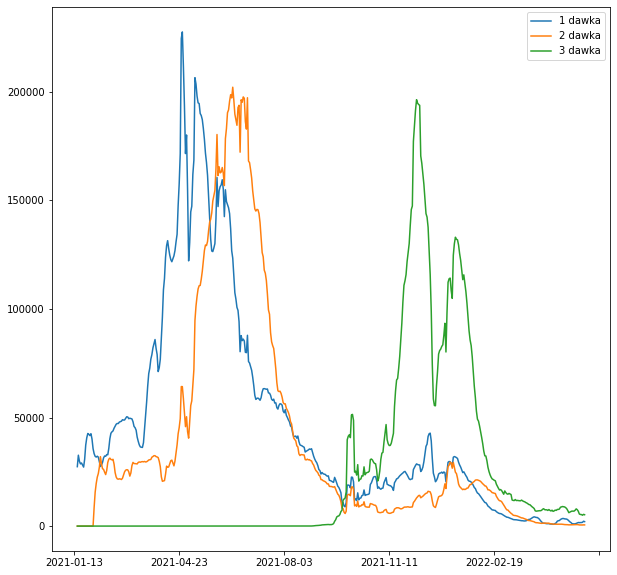

In [517]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
shot1_df.cumsum(axis=1)['szczepienia75_'].rolling(window=7, center=True).mean().plot(ax=ax, label='1 dawka')
shot2_df.cumsum(axis=1)['szczepienia75_'].rolling(window=7, center=True).mean().plot(ax=ax, label='2 dawka')
shot3_df.cumsum(axis=1)['szczepienia75_'].rolling(window=7, center=True).mean().plot(ax=ax, label='3 dawka')
ax.legend()

In [518]:
import random
for col in tqdm(shot1_df):
    random.shuffle(age_group_to_idx_dict[col])

In [519]:
print(future_daily_new_vaccines, future_frequencies)

{'szczepienia0_17': 166.07142857142858, 'szczepienia18_30': 1063.2142857142858, 'szczepienia31_40': 814.5, 'szczepienia41_50': 1039.142857142857, 'szczepienia51_60': 519.2857142857143, 'szczepienia61_70': 141.71428571428572, 'szczepienia71_75': 1127.5714285714287, 'szczepienia75_': 3722.9285714285716} {'shot1': 0.21818493744994039, 'shot2': 0.0727125204583644, 'shot3': 0.7091025420916953}


In [520]:
from datetime import datetime
times = pd.date_range('2022-05-20', periods=289, freq='1d')
future_dates = [f'{x.year}-{x.month:02}-{x.day:02}' for x in times]
future_dates

['2022-05-20',
 '2022-05-21',
 '2022-05-22',
 '2022-05-23',
 '2022-05-24',
 '2022-05-25',
 '2022-05-26',
 '2022-05-27',
 '2022-05-28',
 '2022-05-29',
 '2022-05-30',
 '2022-05-31',
 '2022-06-01',
 '2022-06-02',
 '2022-06-03',
 '2022-06-04',
 '2022-06-05',
 '2022-06-06',
 '2022-06-07',
 '2022-06-08',
 '2022-06-09',
 '2022-06-10',
 '2022-06-11',
 '2022-06-12',
 '2022-06-13',
 '2022-06-14',
 '2022-06-15',
 '2022-06-16',
 '2022-06-17',
 '2022-06-18',
 '2022-06-19',
 '2022-06-20',
 '2022-06-21',
 '2022-06-22',
 '2022-06-23',
 '2022-06-24',
 '2022-06-25',
 '2022-06-26',
 '2022-06-27',
 '2022-06-28',
 '2022-06-29',
 '2022-06-30',
 '2022-07-01',
 '2022-07-02',
 '2022-07-03',
 '2022-07-04',
 '2022-07-05',
 '2022-07-06',
 '2022-07-07',
 '2022-07-08',
 '2022-07-09',
 '2022-07-10',
 '2022-07-11',
 '2022-07-12',
 '2022-07-13',
 '2022-07-14',
 '2022-07-15',
 '2022-07-16',
 '2022-07-17',
 '2022-07-18',
 '2022-07-19',
 '2022-07-20',
 '2022-07-21',
 '2022-07-22',
 '2022-07-23',
 '2022-07-24',
 '2022-07-

In [521]:
times = pd.date_range('2022-06-15', periods=184, freq='1d')
slow_summer_scenario_days = [f'{x.year}-{x.month:02}-{x.day:02}' for x in times]
print(slow_summer_scenario_days)
fast_autumn_scenario_days = [f'{x.year}-{x.month:02}-{x.day:02}' for x in times[92:]]
fast_autumn_scenario_days


['2022-06-15', '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25', '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022

['2022-09-15',
 '2022-09-16',
 '2022-09-17',
 '2022-09-18',
 '2022-09-19',
 '2022-09-20',
 '2022-09-21',
 '2022-09-22',
 '2022-09-23',
 '2022-09-24',
 '2022-09-25',
 '2022-09-26',
 '2022-09-27',
 '2022-09-28',
 '2022-09-29',
 '2022-09-30',
 '2022-10-01',
 '2022-10-02',
 '2022-10-03',
 '2022-10-04',
 '2022-10-05',
 '2022-10-06',
 '2022-10-07',
 '2022-10-08',
 '2022-10-09',
 '2022-10-10',
 '2022-10-11',
 '2022-10-12',
 '2022-10-13',
 '2022-10-14',
 '2022-10-15',
 '2022-10-16',
 '2022-10-17',
 '2022-10-18',
 '2022-10-19',
 '2022-10-20',
 '2022-10-21',
 '2022-10-22',
 '2022-10-23',
 '2022-10-24',
 '2022-10-25',
 '2022-10-26',
 '2022-10-27',
 '2022-10-28',
 '2022-10-29',
 '2022-10-30',
 '2022-10-31',
 '2022-11-01',
 '2022-11-02',
 '2022-11-03',
 '2022-11-04',
 '2022-11-05',
 '2022-11-06',
 '2022-11-07',
 '2022-11-08',
 '2022-11-09',
 '2022-11-10',
 '2022-11-11',
 '2022-11-12',
 '2022-11-13',
 '2022-11-14',
 '2022-11-15',
 '2022-11-16',
 '2022-11-17',
 '2022-11-18',
 '2022-11-19',
 '2022-11-

In [548]:
scenario_4_shots = shot3_df.cumsum().loc['2022-05-19'][-3:]/2
scenario_4_shots

szczepienia61_70    1495751.5
szczepienia71_75     435231.0
szczepienia75_       737248.5
Name: 2022-05-19, dtype: float64

In [559]:
scenario_4_shots.sum()

2668231.0

In [524]:
vax_dates = defaultdict(dict)
shot_df_dict = {'shot1': shot1_df, 'shot2': shot2_df, 'shot3': shot3_df}
for shot, shot_df in shot_df_dict.items():
    for col in tqdm(shot_df):
        age_group_shot = shot_df[col]
        start = 0
        for date, v in age_group_shot[age_group_shot>0].iteritems():
            for subject_id in range(start, start + int(v)):
                vax_dates[shot][age_group_to_idx_dict[col][subject_id]] = date
            start += int(v)
        new_vax_daily = int(future_daily_new_vaccines[col] * future_frequencies[shot] * corrections[shot][col]) 
        for date in future_dates:
            for subject_id in range(start, start + new_vax_daily):
                vax_dates[shot][age_group_to_idx_dict[col][subject_id]] = date
            start += new_vax_daily
#vax_df = pd.DataFrame(vax_dates)

  2%|███▏                                                                                                                                                                                               | 8/490 [00:07<07:20,  1.09it/s]


In [551]:
from dateutil.parser import parse
from datetime import timedelta
shot3_dates = defaultdict(list)
[shot3_dates[date].append(elem) for elem, date in vax_dates['shot3'].items()]
people60plus = []
for group in scenario_4_shots.index:
    people60plus.extend(age_group_to_idx_dict[group])
print(len(people60plus))

8872190


In [593]:
allowed_ids_fast_autumn = []
allowed_ids_slow_summer = []
for date, data in shot3_dates.items():
    if parse(date) + timedelta(days=150) < parse(slow_summer_scenario_days[0]):
        allowed_ids_slow_summer.extend(data)
    if parse(date) + timedelta(days=150) < parse(fast_autumn_scenario_days[0]):
        allowed_ids_fast_autumn.extend(data)
allowed_ids_slow_summer = list(set(allowed_ids_slow_summer).intersection(people60plus))
allowed_ids_fast_autumn = list(set(allowed_ids_fast_autumn).intersection(people60plus))

In [595]:
selected_ids = dict()
for scenario_name, scenario_dates in zip(['fast_autumn', 'slow_summer'], [fast_autumn_scenario_days, slow_summer_scenario_days]):
    selected_ids[scenario_name] = defaultdict(list)
    for date in tqdm(scenario_dates):
        date2 = parse(date) - timedelta(days=150)
        date2 = f'{date2.year}-{date2.month:02}-{date2.day:02}'
        data = list(set(shot3_dates[date2]).intersection(people60plus)) 
        if scenario_name == 'fast_autumn':
            allowed_ids_fast_autumn.extend(data)
        else:
            allowed_ids_slow_summer.extend(data)
        boost4_daily = int(0.5 + scenario_4_shots.sum() / len(scenario_dates))

        if scenario_name == 'fast_autumn':
            random.shuffle(allowed_ids_fast_autumn)
            elems = allowed_ids_fast_autumn[:boost4_daily]
            allowed_ids_fast_autumn = allowed_ids_fast_autumn[boost4_daily:]
            #elem = allowed_ids_fast_autumn.pop(int(random.random() * len(allowed_ids_fast_autumn)))
        else:
            random.shuffle(allowed_ids_slow_summer)
            elems = allowed_ids_slow_summer[:boost4_daily]
            allowed_ids_slow_summer = allowed_ids_slow_summer[boost4_daily:]
            #elem = allowed_ids_slow_summer.pop(int(random.random() * len(allowed_ids_slow_summer)))
        selected_ids[scenario_name][date].extend(elems)
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [10:51<00:00,  3.54s/it]


In [596]:
len(selected_ids['fast_autumn']['2022-10-30'])

29003

In [597]:
len(selected_ids['slow_summer']['2022-10-30'])

14501

In [598]:
14501*182

2639182

In [603]:
slow_summer_vax_dates = vax_dates.copy()
fast_autumn_vax_dates = vax_dates.copy()

In [604]:
shot = 'shot4'
for date, vaccinated in tqdm(selected_ids['slow_summer'].items()):
    for subject_id in vaccinated:
        slow_summer_vax_dates[shot][subject_id] = date

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 191.50it/s]


In [605]:
shot = 'shot4'
for date, vaccinated in tqdm(selected_ids['fast_autumn'].items()):
    for subject_id in vaccinated:
        fast_autumn_vax_dates[shot][subject_id] = date

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 91.30it/s]


In [606]:
df_ss = pd.DataFrame(slow_summer_vax_dates)

In [609]:
df_ss[~df_ss.shot4.isna()]

,shot1,shot2,shot3,shot4
21116644,2021-01-14,2021-02-04,2021-07-06,2022-08-30
18167430,2021-01-14,2021-02-04,2021-07-06,2022-10-19
11113736,2021-01-14,2021-02-04,2021-07-06,2022-07-29
12639539,2021-01-14,2021-02-04,2021-07-06,2022-07-25
32927880,2021-01-14,2021-02-04,2021-07-06,2022-07-07
...,...,...,...,...
9013326,2021-10-15,2022-12-03,2022-07-18,2022-12-15
3715083,2021-10-15,2022-12-04,2022-07-18,2022-12-15
25173059,2021-10-15,2022-12-04,2022-07-18,2022-12-15
35144031,2021-10-15,2022-12-06,2022-07-18,2022-12-15


In [628]:
df_pl_infections = pd.read_csv('/Users/marcinbodych/Workspace/ImmunityUptakes/notebooks/infection_time_id.csv')


In [629]:
df_pl_infections.shape

(32793767, 2)

In [630]:
df_pl_infections.head()

,id,infection_time
0,1,111.990997
1,2,101.392960
2,4,115.235107
3,6,87.804077
4,7,94.778885


In [631]:
offset = 191+30-7
df_pl_infections['infection_time'] -= offset
df_pl_infections.head()

,id,infection_time
0,1,-102.009003
1,2,-112.607040
2,4,-98.764893
3,6,-126.195923
4,7,-119.221115


In [634]:
len(slow_summer_vax_dates['shot1'].keys())

23240798

In [639]:
for i, (subject_id, inf_time) in tqdm(df_pl_infections.iterrows()):
    subject = int(subject_id)
    infection = inf_time
    slow_summer_vax_dates['infection_time'][subject] = infection
    fast_autumn_vax_dates['infection_time'][subject] = infection    

32793767it [13:48, 39588.81it/s]


In [640]:
df_ss = pd.DataFrame(slow_summer_vax_dates)

In [641]:
df_ss.shape

(36126286, 5)

In [642]:
df_ss.head()

,shot1,shot2,shot3,shot4,infection_time
13608689,2021-01-14,2021-02-26,2021-08-31,NaN,-100.285339
32934713,2021-01-14,2021-02-26,2021-08-31,NaN,-92.119125
10209422,2021-01-14,2021-02-26,2021-08-31,NaN,-133.285416
5649426,2021-01-14,2021-02-26,2021-09-01,NaN,-117.564301
1803214,2021-01-14,2021-02-26,2021-09-01,NaN,-108.580582


In [650]:
date = '2021-01-14'
begin_date = '2022-05-22'
(parse(date) - parse(begin_date)).days
parsed_begin_date = parse(begin_date)

datetime.datetime(2022, 5, 22, 0, 0)

In [661]:
for shot in tqdm(['shot2', 'shot3', 'shot4']):
    df_ss[f'parsed_{shot}'] = np.nan
    df_ss.loc[~df_ss[shot].isna(), f'parsed_{shot}'] = df_ss.loc[~df_ss[shot].isna(), shot].map(parse)
    df_ss[f'{shot}_time'] = np.nan
    df_ss.loc[~df_ss[shot].isna(), f'{shot}_time'] = df_ss.loc[~df_ss[shot].isna(), f'parsed_{shot}'].map(calculate_offset_v2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [24:10<00:00, 483.50s/it]


In [663]:
df_ss.head()


,shot1,shot2,shot3,shot4,infection_time,parsed_shot1,shot1_time,parsed_shot2,shot2_time,parsed_shot3,shot3_time,parsed_shot4,shot4_time
13608689,2021-01-14,2021-02-26,2021-08-31,NaN,-100.285339,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-08-31 00:00:00,-264.0,NaN,NaN
32934713,2021-01-14,2021-02-26,2021-08-31,NaN,-92.119125,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-08-31 00:00:00,-264.0,NaN,NaN
10209422,2021-01-14,2021-02-26,2021-08-31,NaN,-133.285416,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-08-31 00:00:00,-264.0,NaN,NaN
5649426,2021-01-14,2021-02-26,2021-09-01,NaN,-117.564301,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-09-01 00:00:00,-263.0,NaN,NaN
1803214,2021-01-14,2021-02-26,2021-09-01,NaN,-108.580582,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-09-01 00:00:00,-263.0,NaN,NaN


<AxesSubplot:xlabel='x'>

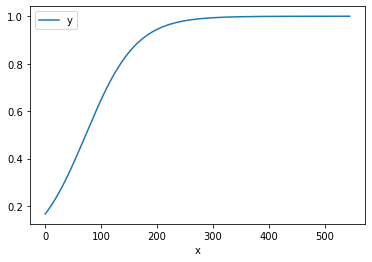

In [664]:
x=np.arange(0,545,0.1)
# y=(1)/(1+0.2*np.exp(x/120))
y=1-1/(1+0.2*np.exp(x/45))
pd.DataFrame({'x':x, 'y':y}).plot(x='x',y='y')

<AxesSubplot:xlabel='x'>

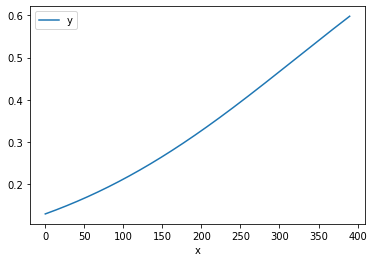

In [701]:
x=np.arange(0,390,0.1)
# y=(1)/(1+0.2*np.exp(x/120))
#y=1-1/(1+0.1*np.exp(x/100))

y=1-1/(1+0.15*np.exp(x/170))
pd.DataFrame({'x':x, 'y':y}).plot(x='x',y='y')

In [666]:
!pip install scipy

  Using cached scipy-1.8.1-cp39-cp39-macosx_12_0_universal2.macosx_10_9_x86_64.whl (55.6 MB)
You should consider upgrading via the '/Users/marcinbodych/Workspace/ImmunityUptakes/venv/bin/python3.9 -m pip install --upgrade pip' command.


In [667]:
from scipy import stats
class deterministic_gen(stats.rv_continuous):
    def _cdf(self, x):
        return 1-1/(1+0.2*np.exp(x/45))
    def _stats(self):
        return 0., 0., 0., 0.

In [710]:
np.log(5 / (1 - 0) - 5)

/var/folders/dg/w1lj0pmn0kg4q2x6y3397nj80000gn/T/ipykernel_81084/2839617334.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(5 / (1 - 0) - 5)


-inf

In [711]:
def f_inverse(y):
    return 120 * np.log(5 / (1 - y) - 5)

array([0.34245835, 0.64524499, 0.20235599, 0.94923434, 0.90891678,
       0.93995943, 0.93987683, 0.25449558, 0.44610538, 0.23089458,
       0.36944997, 0.90773519, 0.94314872, 0.15499891, 0.80895779,
       0.23728603, 0.29084916, 0.4743016 , 0.77556399, 0.05344889,
       0.95204223, 0.19416921, 0.41267949, 0.63820027, 0.70961833,
       0.70853941, 0.16347783, 0.51425544, 0.16351575, 0.73784562,
       0.16703039, 0.13642551, 0.02387451, 0.71407197, 0.73317578,
       0.49795635, 0.97119991, 0.97924897, 0.41994641, 0.66712555,
       0.37686195, 0.29254178, 0.47417318, 0.4545932 , 0.83113294,
       0.17507615, 0.89413447, 0.04939729, 0.56971314, 0.57823378,
       0.87002866, 0.03534705, 0.68046756, 0.28753888, 0.09091791,
       0.57562708, 0.73024468, 0.92093736, 0.93555943, 0.36813671,
       0.29610367, 0.56306543, 0.02591571, 0.46397094, 0.24219768,
       0.94333089, 0.12922866, 0.44044848, 0.26972164, 0.81429239,
       0.37166002, 0.79063871, 0.69133581, 0.88213308, 0.25289

In [702]:
from scipy import stats
class deterministic_gen2(stats.rv_continuous):
    def _cdf(self, x):
        return 1-1/(1+0.2*np.exp(x/120))
    def _stats(self):
        return 0., 0., 0., 0.
deterministic_slow = deterministic_gen2(name="120")

class deterministic_severe(stats.rv_continuous):
    def _cdf(self, x):
        return 1-1/(1+0.15*np.exp(x/170))
    def _stats(self):
        return 0.,0.,0.,0.

In [668]:
deterministic = deterministic_gen(name="45")

In [703]:
deterministic_s = deterministic_severe(name="severe")

In [674]:
np.maximum(0, deterministic.rvs(size=5))

array([ 51.3770155 ,  99.675809  ,   0.        ,  74.7165352 ,
       117.82684461])

In [676]:
df_ss1 = df_ss.copy()
df_ss2 = df_ss.copy()


In [721]:
f_inverse(np.arange(0, 1, 0.001))

/var/folders/dg/w1lj0pmn0kg4q2x6y3397nj80000gn/T/ipykernel_81084/2320801919.py:2: RuntimeWarning: divide by zero encountered in log
  return 120 * np.log(5 / (1 - y) - 5)


array([           -inf, -6.35678024e+02, -5.52380182e+02, -5.03604068e+02,
       -4.68961798e+02, -4.42064029e+02, -4.20064779e+02, -4.01445912e+02,
       -3.85301238e+02, -3.71046245e+02, -3.58281833e+02, -3.46723338e+02,
       -3.36160576e+02, -3.26433932e+02, -3.17419334e+02, -3.09018423e+02,
       -3.01151911e+02, -2.93754944e+02, -2.86773797e+02, -2.80163468e+02,
       -2.73885886e+02, -2.67908555e+02, -2.62203517e+02, -2.56746543e+02,
       -2.51516501e+02, -2.46494848e+02, -2.41665222e+02, -2.37013116e+02,
       -2.32525606e+02, -2.28191127e+02, -2.23999293e+02, -2.19940739e+02,
       -2.16006993e+02, -2.12190363e+02, -2.08483848e+02, -2.04881055e+02,
       -2.01376133e+02, -1.97963710e+02, -1.94638845e+02, -1.91396982e+02,
       -1.88233910e+02, -1.85145731e+02, -1.82128830e+02, -1.79179844e+02,
       -1.76295644e+02, -1.73473313e+02, -1.70710124e+02, -1.68003527e+02,
       -1.65351133e+02, -1.62750702e+02, -1.60200128e+02, -1.57697430e+02,
       -1.55240745e+02, -

In [718]:
import time
for i in [100, 1000, 10000, 100000]:
    t = time.time()
    f_inverse(np.random.uniform(size=i))
    print(i, time.time() - t)

100 6.699562072753906e-05
1000 8.869171142578125e-05
10000 0.0002779960632324219
100000 0.0021419525146484375


In [722]:
def f_inverse_slow(y):
    return 120 * np.log(5 / (1 - y) - 5)
def f_inverse_fast(y):
    return 45 * np.log(5 / (1 - y) - 5)
def f_inverse_severe(y):
    return 170 * np.log((1/0.15) / (1 - y) - (1/0.15))

In [727]:
for shot in tqdm(['shot2', 'shot3', 'shot4', 'infection_time']):
    df_ss[f'{shot}_infection_immunity_slow_length'] = np.nan
    df_ss[f'{shot}_infection_immunity_fast_length'] = np.nan
    df_ss[f'{shot}_severe_immunity_length'] = np.nan
    logic = ~df_ss[shot].isna()
    rand_size = sum(logic)
    df_ss.loc[logic, f'{shot}_infection_immunity_slow_length'] = np.maximum(0, f_inverse_slow(np.random.uniform(size=rand_size)))
    df_ss.loc[logic, f'{shot}_infection_immunity_fast_length'] = np.maximum(0, f_inverse_fast(np.random.uniform(size=rand_size)))
    df_ss.loc[logic, f'{shot}_severe_immunity_length'] = np.maximum(0, f_inverse_severe(np.random.uniform(size=rand_size)))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.45s/it]


In [729]:
df_fa = pd.DataFrame(fast_autumn_vax_dates)
for shot in tqdm(['shot2', 'shot3', 'shot4']):
    df_fa[f'parsed_{shot}'] = np.nan
    logic = ~df_fa[shot].isna()
    df_fa.loc[logic, f'parsed_{shot}'] = df_fa.loc[logic, shot].map(parse)
    df_fa[f'{shot}_time'] = np.nan
    df_fa.loc[logic, f'{shot}_time'] = df_fa.loc[logic, f'parsed_{shot}'].map(calculate_offset_v2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [24:14<00:00, 484.89s/it]


In [730]:
for shot in tqdm(['shot2', 'shot3', 'shot4', 'infection_time']):
    df_fa[f'{shot}_infection_immunity_slow_length'] = np.nan
    df_fa[f'{shot}_infection_immunity_fast_length'] = np.nan
    df_fa[f'{shot}_severe_immunity_length'] = np.nan
    logic = ~df_fa[shot].isna()
    rand_size = sum(logic)
    df_fa.loc[logic, f'{shot}_infection_immunity_slow_length'] = np.maximum(0, f_inverse_slow(np.random.uniform(size=rand_size)))
    df_fa.loc[logic, f'{shot}_infection_immunity_fast_length'] = np.maximum(0, f_inverse_fast(np.random.uniform(size=rand_size)))
    df_fa.loc[logic, f'{shot}_severe_immunity_length'] = np.maximum(0, f_inverse_severe(np.random.uniform(size=rand_size)))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.13s/it]


In [731]:
df_ss.head()

,shot1,shot2,shot3,shot4,infection_time,parsed_shot1,shot1_time,parsed_shot2,shot2_time,parsed_shot3,...,shot2_infection_immunity_fast_length,shot3_infection_immunity_slow_length,shot3_infection_immunity_fast_length,shot3_severe_immunity_length,shot4_infection_immunity_slow_length,shot4_infection_immunity_fast_length,shot4_severe_immunity_length,infection_time_infection_immunity_slow_length,infection_time_infection_immunity_fast_length,infection_time_severe_immunity_length
13608689,2021-01-14,2021-02-26,2021-08-31,NaN,-100.285339,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-08-31 00:00:00,...,61.399555,273.563501,42.190614,458.035469,NaN,NaN,NaN,0.000000,109.631444,390.004269
32934713,2021-01-14,2021-02-26,2021-08-31,NaN,-92.119125,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-08-31 00:00:00,...,29.033901,121.208444,135.637184,0.604573,NaN,NaN,NaN,0.000000,217.799013,506.763753
10209422,2021-01-14,2021-02-26,2021-08-31,NaN,-133.285416,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-08-31 00:00:00,...,0.000000,103.579720,0.000000,919.461420,NaN,NaN,NaN,420.075589,64.357537,173.631043
5649426,2021-01-14,2021-02-26,2021-09-01,NaN,-117.564301,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-09-01 00:00:00,...,17.970207,239.744203,0.000000,584.860494,NaN,NaN,NaN,383.717985,70.642382,532.072540
1803214,2021-01-14,2021-02-26,2021-09-01,NaN,-108.580582,2021-01-14 00:00:00,-493.0,2021-02-26 00:00:00,-450.0,2021-09-01 00:00:00,...,65.364512,888.043696,149.823476,309.506066,NaN,NaN,NaN,159.213910,52.265770,271.424639


In [732]:
df_ss.columns

Index(['shot1', 'shot2', 'shot3', 'shot4', 'infection_time', 'parsed_shot1',
       'shot1_time', 'parsed_shot2', 'shot2_time', 'parsed_shot3',
       'shot3_time', 'parsed_shot4', 'shot4_time',
       'shot2_infection_immunity_length', 'shot2_severe_immunity_length',
       'shot2_infection_immunity_slow_length',
       'shot2_infection_immunity_fast_length',
       'shot3_infection_immunity_slow_length',
       'shot3_infection_immunity_fast_length', 'shot3_severe_immunity_length',
       'shot4_infection_immunity_slow_length',
       'shot4_infection_immunity_fast_length', 'shot4_severe_immunity_length',
       'infection_time_infection_immunity_slow_length',
       'infection_time_infection_immunity_fast_length',
       'infection_time_severe_immunity_length'],
      dtype='object')

In [779]:
t = df_ss[[
    'shot2_time', 'shot2_infection_immunity_slow_length', 'shot2_infection_immunity_fast_length', 'shot2_severe_immunity_length',
    'shot3_time', 'shot3_infection_immunity_slow_length', 'shot3_infection_immunity_fast_length', 'shot3_severe_immunity_length',
    'shot4_time', 'shot4_infection_immunity_slow_length', 'shot4_infection_immunity_fast_length', 'shot4_severe_immunity_length',
    'infection_time', 'infection_time_infection_immunity_slow_length', 'infection_time_infection_immunity_fast_length', 'infection_time_severe_immunity_length'
]]

In [788]:
t100 = t.copy()#head(n=10000)

In [758]:
def merge_intervals(intervals):
    last_interval_right = -np.inf
    new_intervals = []
    for interval in intervals:
        if last_interval_right > interval[0]:
            if interval[1] > new_intervals[-1][1]:
                new_intervals[-1] = (new_intervals[-1][0], interval[1])
        else:
            new_intervals.append(interval)
        last_interval_right = new_intervals[-1][1]
    return new_intervals
assert merge_intervals([(-450.0, -388.08815441601973), (-262.0, 171.82276717909855), (-121.58807373046876, 139.43852787063128)]) == [(-450.0, -388.08815441601973), (-262.0, 171.82276717909855)]
assert merge_intervals([(-450.0, -98.18193917439731), (-261.0, -65.57682105474325), (-48.696563720703125, 369.38209852728943)]) == [(-450.0, -65.57682105474325), (-48.696563720703125, 369.38209852728943)]
assert merge_intervals([]) == []
assert merge_intervals([(-261.0, -201.99558921086415)]) == [(-261.0, -201.99558921086415)]
assert merge_intervals([(-429.0, -421.32444186516585), (-260.0, -237.5430012736313), (-111.04547119140624, 521.5115349397345)]) == [(-429.0, -421.32444186516585), (-260.0, -237.5430012736313), (-111.04547119140624, 521.5115349397345)]


In [789]:
from collections import namedtuple
columns_slow = [
    'shot2_time', 'shot2_infection_immunity_slow_length', 'shot2_severe_immunity_length',
    'shot3_time', 'shot3_infection_immunity_slow_length', 'shot3_severe_immunity_length',
    'shot4_time', 'shot4_infection_immunity_slow_length', 'shot4_severe_immunity_length',
    'infection_time', 'infection_time_infection_immunity_slow_length', 'infection_time_severe_immunity_length'
]
columns_fast = [
    'shot2_time', 'shot2_infection_immunity_fast_length', 'shot2_severe_immunity_length',
    'shot3_time', 'shot3_infection_immunity_fast_length', 'shot3_severe_immunity_length',
    'shot4_time', 'shot4_infection_immunity_fast_length', 'shot4_severe_immunity_length',
    'infection_time', 'infection_time_infection_immunity_fast_length', 'infection_time_severe_immunity_length'
]

global counter1
def convert_to_intervals(s2, s21, s22, s3, s31, s32, s4, s41, s42, i, i1, i2):
    global counter1
    counter1 += 1
    if counter1 % 1000000 == 0:
        print(counter1)
    intervals = []
    if pd.isna(s2) is False:
        if s21 > 0:
            intervals.append((s2, s2 + s21))
    if pd.isna(s3) is False:
        if s31 > 0:
            intervals.append((s3, s3 + s31))
    if pd.isna(s4) is False:
        if s41 > 0:
            intervals.append((s4, s4 + s41))
    if pd.isna(i) is False:
        if i1 > 0:
            intervals.append((i, i + i1))
    return merge_intervals(intervals)

def convert_to_intervals2(s2, s21, s22, s3, s31, s32, s4, s41, s42, i, i1, i2):
    global counter1
    counter1 += 1
    if counter1 % 1000000 == 0:
        print(counter1)
    intervals_severe = []
    if pd.isna(s2) is False:
        if s22 > 0:
            intervals_severe.append((s2, s2 + s22))
    if pd.isna(s3) is False:
        if s32 > 0:
            intervals_severe.append((s3, s3 + s32))
    if pd.isna(s4) is False:
        if s42 > 0:
            intervals_severe.append((s4, s4 + s42))
    if pd.isna(i) is False:
        if i2 > 0:
            intervals_severe.append((i, i + i2))
    return merge_intervals(intervals_severe)
   
counter1 = 0
t100['as'] = t100[columns_slow].apply(lambda x: convert_to_intervals(*x), axis=1)
counter1 = 0
t100['bs'] = t100[columns_slow].apply(lambda x: convert_to_intervals2(*x), axis=1)

counter1 = 0
t100['af'] = t100[columns_fast].apply(lambda x: convert_to_intervals(*x), axis=1)
counter1 = 0
t100['bf'] = t100[columns_fast].apply(lambda x: convert_to_intervals2(*x), axis=1)

events_slow = []
events_fast = []
Row = namedtuple('Row', ['subject_id', 'immunity_uptake_time', 'lost_immunity_time', 'immunity_type'])

for events, (an, bn) in zip([events_slow, events_fast], [('as', 'bs'), ('af', 'bf')]):
    for i, (a, b) in tqdm(t100[['as', 'bs']].iterrows()):
        for elem_start, elem_end in a:
            if elem_end >= 0:
                events.append(Row(i, elem_start, elem_end, 'against_infection'))
        for elem_start, elem_end in b:
            if elem_end >= 0:
                events.append(Row(i, elem_start, elem_end, 'against_severe_progression'))


1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
1000000
2000000
3000000
4000000
5000000
6000000
7000000

36126286it [21:55, 27463.21it/s]
36126286it [35:39, 16885.21it/s]


In [790]:
df_ss_ef = pd.DataFrame(events_fast)

In [791]:
df_ss_ef.tail()

,subject_id,immunity_uptake_time,lost_immunity_time,immunity_type
59479176,37498007,-112.129532,332.577516,against_severe_progression
59479177,37498008,-102.204010,12.171306,against_infection
59479178,37498008,-102.204010,506.035898,against_severe_progression
59479179,37498010,-113.753983,166.599692,against_infection
59479180,37498010,-113.753983,106.546807,against_severe_progression


In [792]:
df_ss_es = pd.DataFrame(events_slow)

In [ ]:
df_ss_ef.to_csv('slow_summer_pessimistic_events.csv')

In [ ]:
df_ss_es.to_csv('slow_summer_optimistic_events.csv')

In [ ]:
t = df_fa[[
    'shot2_time', 'shot2_infection_immunity_slow_length', 'shot2_infection_immunity_fast_length', 'shot2_severe_immunity_length',
    'shot3_time', 'shot3_infection_immunity_slow_length', 'shot3_infection_immunity_fast_length', 'shot3_severe_immunity_length',
    'shot4_time', 'shot4_infection_immunity_slow_length', 'shot4_infection_immunity_fast_length', 'shot4_severe_immunity_length',
    'infection_time', 'infection_time_infection_immunity_slow_length', 'infection_time_infection_immunity_fast_length', 'infection_time_severe_immunity_length'
]]

In [ ]:
t100 = t.copy()#head(n=10000)

In [ ]:
from collections import namedtuple
columns_slow = [
    'shot2_time', 'shot2_infection_immunity_slow_length', 'shot2_severe_immunity_length',
    'shot3_time', 'shot3_infection_immunity_slow_length', 'shot3_severe_immunity_length',
    'shot4_time', 'shot4_infection_immunity_slow_length', 'shot4_severe_immunity_length',
    'infection_time', 'infection_time_infection_immunity_slow_length', 'infection_time_severe_immunity_length'
]
columns_fast = [
    'shot2_time', 'shot2_infection_immunity_fast_length', 'shot2_severe_immunity_length',
    'shot3_time', 'shot3_infection_immunity_fast_length', 'shot3_severe_immunity_length',
    'shot4_time', 'shot4_infection_immunity_fast_length', 'shot4_severe_immunity_length',
    'infection_time', 'infection_time_infection_immunity_fast_length', 'infection_time_severe_immunity_length'
]

global counter1
def convert_to_intervals(s2, s21, s22, s3, s31, s32, s4, s41, s42, i, i1, i2):
    global counter1
    counter1 += 1
    if counter1 % 1000000 == 0:
        print(counter1)
    intervals = []
    if pd.isna(s2) is False:
        if s21 > 0:
            intervals.append((s2, s2 + s21))
    if pd.isna(s3) is False:
        if s31 > 0:
            intervals.append((s3, s3 + s31))
    if pd.isna(s4) is False:
        if s41 > 0:
            intervals.append((s4, s4 + s41))
    if pd.isna(i) is False:
        if i1 > 0:
            intervals.append((i, i + i1))
    return merge_intervals(intervals)

def convert_to_intervals2(s2, s21, s22, s3, s31, s32, s4, s41, s42, i, i1, i2):
    global counter1
    counter1 += 1
    if counter1 % 1000000 == 0:
        print(counter1)
    intervals_severe = []
    if pd.isna(s2) is False:
        if s22 > 0:
            intervals_severe.append((s2, s2 + s22))
    if pd.isna(s3) is False:
        if s32 > 0:
            intervals_severe.append((s3, s3 + s32))
    if pd.isna(s4) is False:
        if s42 > 0:
            intervals_severe.append((s4, s4 + s42))
    if pd.isna(i) is False:
        if i2 > 0:
            intervals_severe.append((i, i + i2))
    return merge_intervals(intervals_severe)
   
counter1 = 0
t100['as'] = t100[columns_slow].apply(lambda x: convert_to_intervals(*x), axis=1)
counter1 = 0
t100['bs'] = t100[columns_slow].apply(lambda x: convert_to_intervals2(*x), axis=1)

counter1 = 0
t100['af'] = t100[columns_fast].apply(lambda x: convert_to_intervals(*x), axis=1)
counter1 = 0
t100['bf'] = t100[columns_fast].apply(lambda x: convert_to_intervals2(*x), axis=1)

events_slow = []
events_fast = []
Row = namedtuple('Row', ['subject_id', 'immunity_uptake_time', 'lost_immunity_time', 'immunity_type'])

for events, (an, bn) in zip([events_slow, events_fast], [('as', 'bs'), ('af', 'bf')]):
    for i, (a, b) in tqdm(t100[['as', 'bs']].iterrows()):
        for elem_start, elem_end in a:
            if elem_end >= 0:
                events.append(Row(i, elem_start, elem_end, 'against_infection'))
        for elem_start, elem_end in b:
            if elem_end >= 0:
                events.append(Row(i, elem_start, elem_end, 'against_severe_progression'))


In [ ]:
df_fa_ef = pd.DataFrame(events_fast)

In [ ]:
df_fa_es = pd.DataFrame(events_slow)

In [ ]:
df_fa_ef.to_csv('fast_autumn_pessimistic_events.csv')

In [ ]:
df_fa_es.to_csv('fast_autumn_optimistic_events.csv')